<a href="https://colab.research.google.com/github/chiuannica/MudkipInfographics/blob/master/predictEthereumPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [202]:
plt.style.use("fivethirtyeight")
#ETH for all of history
#path = "/ETH_USD_2015-08-09_2021-02-05-CoinDesk.csv"
#ETH past 3 months
path = "/ETH_USD_2020-11-06_2021-02-05-CoinDesk.csv"
#Doge past 3 months
#path = "/DOGE_USD_2020-11-06_2021-02-05-CoinDesk.csv"
eth_data = pd.read_csv(path)

eth_data.shape
eth_data.rename(columns={"Date": 'date', "Closing Price (USD)": 'close', "24h Open (USD)": 'open', '24h High (USD)': 'high', '24h Low (USD)': 'low'}, inplace=True)

In [203]:
eth_data['date'] = pd.to_datetime(eth_data['date'])
eth_data.index = eth_data['date']
eth_data.tail()

,Currency,date,close,open,high,low
date,,,,,,
2021-02-01,ETH,2021-02-01,1357.047990,1314.419019,1364.277491,1271.988289
2021-02-02,ETH,2021-02-02,1540.651288,1374.482798,1549.033703,1361.935211
2021-02-03,ETH,2021-02-03,1644.685967,1513.809609,1650.388472,1510.619675
2021-02-04,ETH,2021-02-04,1628.468008,1665.892805,1697.107183,1558.583689
2021-02-05,ETH,2021-02-05,1704.832300,1596.991934,1761.354780,1592.854835


Text(0, 0.5, 'close')

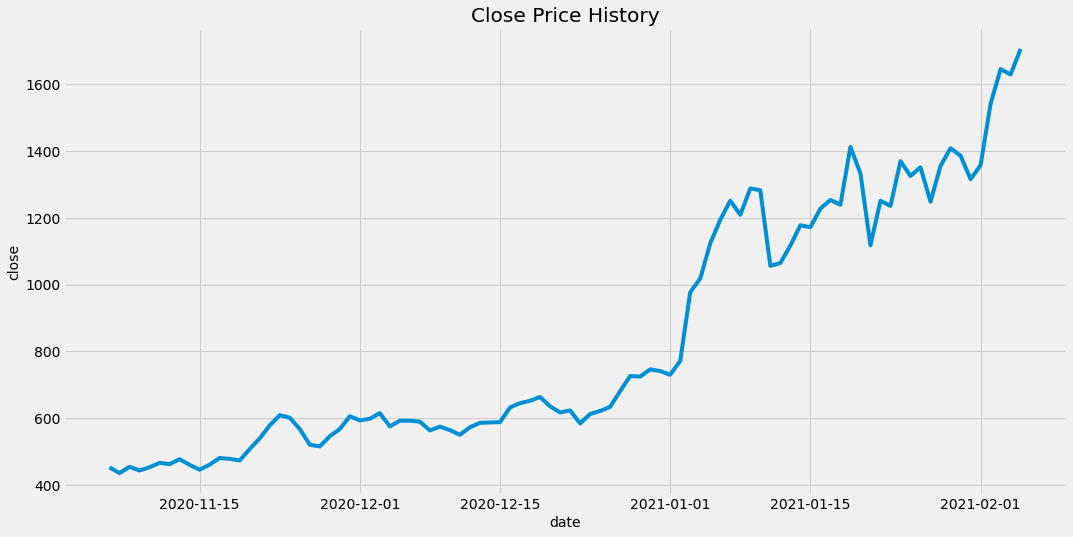

In [204]:
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(eth_data["close"])
plt.xlabel("date", fontsize="14")
plt.ylabel("close", fontsize="14")

In [205]:
# get number of rows to train the model
data = eth_data.filter(['close'])
close_data = data.values

training_data_len = math.ceil(len(close_data) * 0.8)

In [206]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
# calculates the min and max and scales it between 0 and 1
scaled_data = scaler.fit_transform(close_data)

In [207]:
# create training data set
# trained data set
train_data = scaled_data[0:training_data_len, : ]

# split data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.01353024, 0.        , 0.01472879, 0.00611447, 0.01375734,
       0.02416674, 0.02112784, 0.03268596, 0.01938985, 0.00790625,
       0.01985941, 0.03556397, 0.03352562, 0.02971903, 0.05655685,
       0.08172075, 0.11237581, 0.13655346, 0.13055485, 0.10395402,
       0.06696133, 0.06278543, 0.08680443, 0.10387958, 0.13388943,
       0.12435109, 0.12797953, 0.14149066, 0.11011384, 0.12336599,
       0.1235289 , 0.12120189, 0.10053498, 0.10957046, 0.10128878,
       0.09024581, 0.10807734, 0.11856843, 0.11934253, 0.12012612,
       0.15479468, 0.164869  , 0.17048041, 0.17942964, 0.1573893 ,
       0.14294501, 0.14782203, 0.11714695, 0.13925682, 0.14638267,
       0.15607803, 0.19339934, 0.22872332, 0.2275187 , 0.24445097,
       0.24055481, 0.23182077, 0.26447762, 0.42635439, 0.45864017])]
[0.5416211435515323]



In [208]:
# convert the x_train and y_train to numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# reshape bc need 3 dimensions
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(14, 60, 1)

In [209]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [210]:
# optimizer improves upon loss function
model.compile(optimizer='adam', loss='mean_squared_error')


In [211]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

14/14 [==============================] - 3s 23ms/step - loss: 0.2101


In [212]:
# create test data set
# create a new array containing scaled values 
test_data = scaled_data[training_data_len - 60:, : ]
# create the data sets x_test and y_test
x_test = []
y_test = close_data[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [213]:
# convert the data to a numpy array
x_test = np.array(x_test)
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [214]:
# Get the predicted price
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [215]:
# get the root mean squared error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

286.90048122465555

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


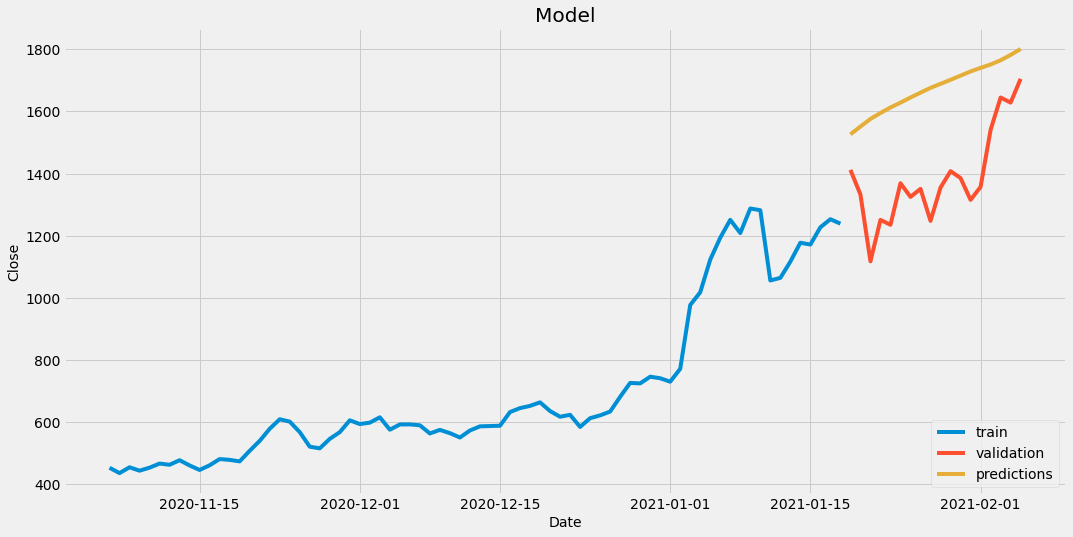

In [216]:
# train and validation
train = data[0:training_data_len]
valid = data[training_data_len:]

valid["predictions"] = predictions
# plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close', fontsize=14)
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['train', 'validation', 'predictions'], loc='lower right')
plt.show()

In [217]:
# show valid and predicted price
valid.tail(20)

,close,predictions
date,,
2021-01-19,1411.833939,1526.171875
2021-01-20,1332.642513,1551.348145
2021-01-21,1117.483678,1575.788208
2021-01-22,1250.715166,1594.931396
2021-01-23,1235.091640,1612.669312
2021-01-24,1368.895605,1628.257080
2021-01-25,1324.858487,1644.711182
2021-01-26,1350.736956,1660.386108
2021-01-27,1247.656556,1675.862061
